# Overview

# 0. Load and configure libraries

In [43]:
# Import libraries to manipulate data
import pandas
import numpy 
import scipy

# Import library for visualizing data
import matplotlib
import matplotlib.pyplot as pyplot

# Import the progress so we can display progress for long running calculations in real time
import progressbar

# Import webcolors to help us identify the colors being automatically assigned to our graphs
import webcolors

# Import a utility class to help us define a custom object
from sortedcontainers import SortedDict

# Import library for clustering
import sklearn

# Import library for optimization
import kneed

In [13]:
# Tell pandas to supress scientific notation and display decimals with 5 places
pandas.set_option('display.float_format', lambda x: '%.5f' % x)

# We can undo this operation with:
#pandas.reset_option('display.float_format')

# 1. Load Data

Load our OHCLV data Into a dataframe and pull out a single day

In [14]:
# Import the utilities module we wrote
import importlib.util
spec = importlib.util.spec_from_file_location("utilities", "../../Utilities/utilities.py")
utilities = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utilities)

# Read the file into a dataframe
file_path = "../../nasdaq_2019.csv"
converter_mapping = {
    "date": utilities.convert_date_string_to_date
}
pandas_dataframe = pandas.read_csv(file_path, converters=converter_mapping)

# Sort based on the date column
pandas_dataframe = pandas_dataframe.sort_values("date")
df_01_01_2019 = pandas_dataframe.loc[pandas_dataframe["date"] == '2019-01-01']
df_01_01_2019.head()

,ticker,interval,date,open,high,low,close,volume
96004,RAND,D,2019-01-01,2.50000,2.50000,2.50000,2.50000,0
95734,OPTT,D,2019-01-01,0.34000,0.34000,0.34000,0.34000,0
95735,ORBC,D,2019-01-01,8.26000,8.26000,8.26000,8.26000,0
95736,ORG,D,2019-01-01,24.49000,24.49000,24.49000,24.49000,0
95737,ORGS,D,2019-01-01,4.68000,4.68000,4.68000,4.68000,0


# 2. Transform Data: Add features for analysis

In [15]:
# Add some additional columns to the data
pandas_dataframe["d_open"] = 0
pandas_dataframe["d2_open"] = 0
pandas_dataframe["ma_open"] = 0
pandas_dataframe["prev_open"] = 0

tickers = numpy.sort(pandas_dataframe["ticker"].unique())

# Create a progress bar to keep us updates while the numbers crunch
num_ops = len(tickers)
progress_bar_widgets = [
    progressbar.Bar('=', '[', ']'), 
    ' ', 
    progressbar.FormatLabel('Processed: %(value)d / {0} ops'.format(num_ops)),
    ' ', 
    progressbar.ETA()
]
bar = progressbar.ProgressBar(maxval=num_ops, widgets=progress_bar_widgets)
bar.start()
count = 0

for ticker in tickers:
    ticker_df = pandas_dataframe[pandas_dataframe["ticker"] == ticker]
    d_open = ticker_df["open"].diff()
    pandas_dataframe.loc[ticker_df.index, "d_open"] = d_open
    pandas_dataframe.loc[ticker_df.index, "d2_open"] = d_open.diff()
    pandas_dataframe.loc[ticker_df.index, "ma_open"] = ticker_df["open"].rolling(5).mean()
    pandas_dataframe.loc[ticker_df.index, "prev_open"] = ticker_df["open"].shift(1)
    count += 1
    bar.update(count)

In [16]:
pandas_dataframe[pandas_dataframe["ma_open"].isnull() == False].head()

,ticker,interval,date,open,high,low,close,volume,d_open,d2_open,ma_open,prev_open
108484,ORGS,D,2019-01-07,4.94000,5.08000,4.87000,5.03000,4600,0.30000,0.61000,4.72600,4.64000
108483,ORG,D,2019-01-07,25.46000,25.66000,25.46000,25.62000,1800,0.06000,-0.66000,24.97000,25.40000
108482,ORBC,D,2019-01-07,8.53000,8.81000,8.49000,8.66000,359800,0.11000,0.15000,8.36600,8.42000
108478,OPRA,D,2019-01-07,6.22000,6.32000,6.17000,6.24000,126200,0.09000,0.03000,5.89800,6.13000
108480,OPTN,D,2019-01-07,7.09000,7.61000,6.68000,7.50000,392900,0.29000,0.29000,6.61800,6.80000


# 3. Clustering Algorithm: K-Means

We can use the K-Means algorithm to logically group the tickers based on their characteristics and behavior. Feel free to review the notebook on K-Means for more detail.

In [20]:
from sklearn.cluster import KMeans

def fit_kmeans_to_data(x, y, num_clusters, random_state=42):
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=random_state)
    df = pandas.DataFrame({
        "x": x,
        "y": y
    })
    fit = kmeans.fit(df)
    centroids = kmeans.cluster_centers_
    return fit, centroids, kmeans

We apply the kmeans algorithm to a specific date to understand how it affects that dataframe. We can create clusters based on the following parameters:

```
model_parameters = df_07_11_2019[["open", "d_open", "d2_open", "ma_open", "prev_open"]]
```

In [21]:
# Get a subset of our data for a particular date
df_07_11_2019 = pandas_dataframe[pandas_dataframe["date"] == '2019-07-11'].copy()
df_07_11_2019.head()

# Remove any bad data
df_07_11_2019 = df_07_11_2019[~df_07_11_2019.isin([numpy.nan, numpy.inf, -numpy.inf]).any(1)]

# Create an instance of our model
model = KMeans(n_clusters=5, random_state=42)

# Set the parameters for our model
model_parameters = df_07_11_2019[["open", "d_open", "d2_open", "ma_open", "prev_open"]]
fit = model.fit(model_parameters)

# Set the clusters and centroids
df_07_11_2019["cluster"] = fit.labels_.astype(int)
centroids = model.cluster_centers_
df_07_11_2019["centroid"] = [centroids[i] for i in df_07_11_2019["cluster"]]

In [22]:
df_07_11_2019.head()

,ticker,interval,date,open,high,low,close,volume,d_open,d2_open,ma_open,prev_open,cluster,centroid
24639,OSS,D,2019-07-11,1.99000,1.99000,1.83010,1.88000,47600,0.02000,0.10000,2.01400,1.97000,0,"[15.994117407271375, -0.021282592728608114, -0..."
24645,OTIC,D,2019-07-11,2.71000,2.71000,2.52000,2.52900,43300,-0.04000,-0.25000,2.63400,2.75000,0,"[15.994117407271375, -0.021282592728608114, -0..."
24640,OSTK,D,2019-07-11,18.39000,18.39000,17.21000,17.82000,4985300,0.94000,0.53000,16.49400,17.45000,0,"[15.994117407271375, -0.021282592728608114, -0..."
24641,OSUR,D,2019-07-11,9.22000,9.22000,8.81500,8.90000,607000,0.05000,-0.11000,9.12000,9.17000,0,"[15.994117407271375, -0.021282592728608114, -0..."
24642,OSW,D,2019-07-11,14.96000,15.00000,14.81000,14.94000,1157000,-0.03000,-0.25000,14.86800,14.99000,0,"[15.994117407271375, -0.021282592728608114, -0..."


To understand the performance of the clustering let't cross plot the features against eachother in pairs.

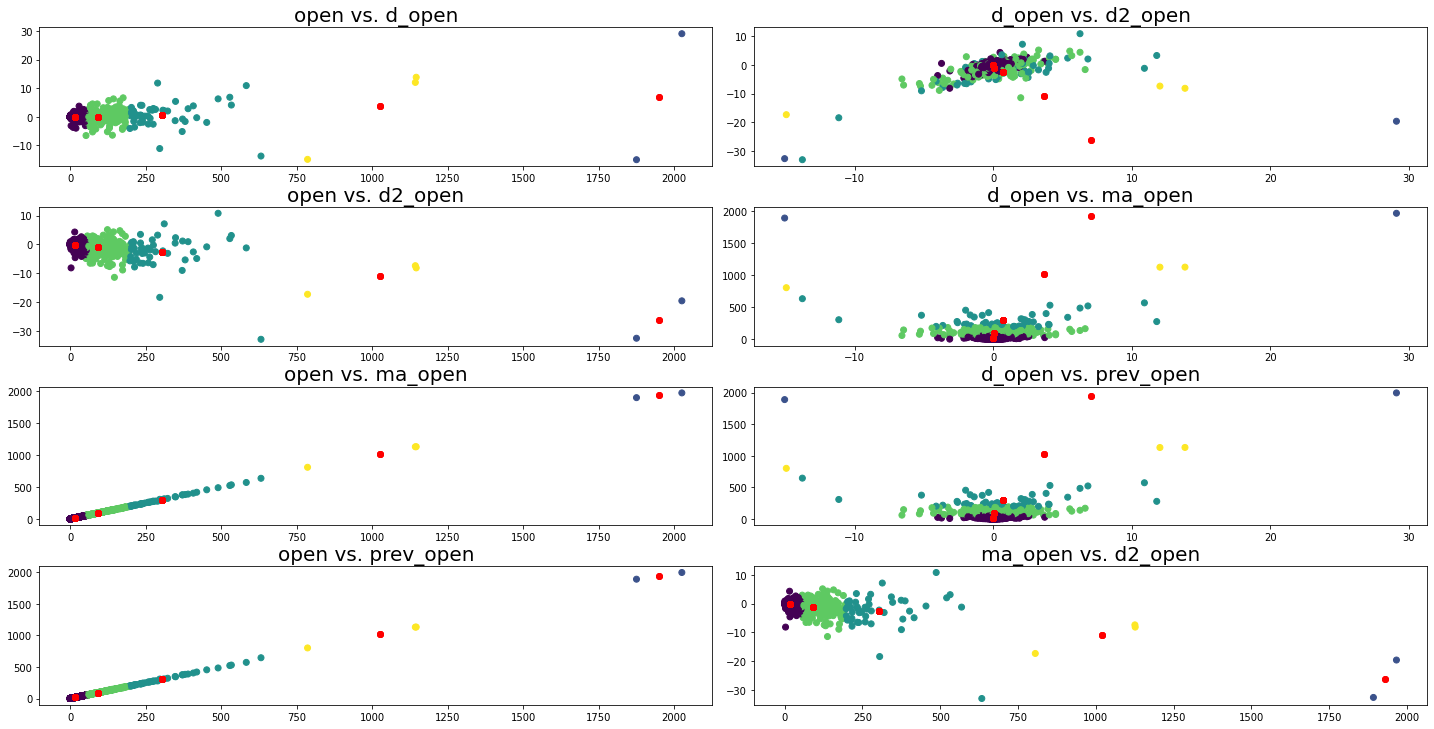

In [23]:
fig, ax = pyplot.subplots(figsize=(20, 10), nrows=4, ncols=2)
fig.tight_layout(h_pad=2)

open_centroid = df_07_11_2019["centroid"].apply(lambda x: x[0])
d_open_centroid = df_07_11_2019["centroid"].apply(lambda x: x[1])
d2_open_centroid = df_07_11_2019["centroid"].apply(lambda x: x[2])
ma_open_centroid = df_07_11_2019["centroid"].apply(lambda x: x[3])
prev_open_centroid = df_07_11_2019["centroid"].apply(lambda x: x[4])

ax[0, 0].set_title("open vs. d_open", fontsize=20);
ax[0, 0].scatter(df_07_11_2019["open"], df_07_11_2019["d_open"], c=df_07_11_2019["cluster"]);
ax[0, 0].scatter(open_centroid, d_open_centroid, c='red');

ax[1, 0].set_title("open vs. d2_open", fontsize=20);
ax[1, 0].scatter(df_07_11_2019["open"], df_07_11_2019["d2_open"], c=df_07_11_2019["cluster"]);
ax[1, 0].scatter(open_centroid, d2_open_centroid, c='red');

ax[2, 0].set_title("open vs. ma_open", fontsize=20);
ax[2, 0].scatter(df_07_11_2019["open"], df_07_11_2019["ma_open"], c=df_07_11_2019["cluster"]);
ax[2, 0].scatter(open_centroid, ma_open_centroid, c='red');

ax[3, 0].set_title("open vs. prev_open", fontsize=20);
ax[3, 0].scatter(df_07_11_2019["open"], df_07_11_2019["prev_open"], c=df_07_11_2019["cluster"]);
ax[3, 0].scatter(open_centroid, prev_open_centroid, c='red');

ax[0, 1].set_title("d_open vs. d2_open", fontsize=20);
ax[0, 1].scatter(df_07_11_2019["d_open"], df_07_11_2019["d2_open"], c=df_07_11_2019["cluster"]);
ax[0, 1].scatter(d_open_centroid, d2_open_centroid, c='red');

ax[1, 1].set_title("d_open vs. ma_open", fontsize=20);
ax[1, 1].scatter(df_07_11_2019["d_open"], df_07_11_2019["ma_open"], c=df_07_11_2019["cluster"]);
ax[1, 1].scatter(d_open_centroid, ma_open_centroid, c='red');

ax[2, 1].set_title("d_open vs. prev_open", fontsize=20);
ax[2, 1].scatter(df_07_11_2019["d_open"], df_07_11_2019["prev_open"], c=df_07_11_2019["cluster"]);
ax[2, 1].scatter(d_open_centroid, prev_open_centroid, c='red');

ax[3, 1].set_title("ma_open vs. d2_open", fontsize=20);
ax[3, 1].scatter(df_07_11_2019["ma_open"], df_07_11_2019["d2_open"], c=df_07_11_2019["cluster"]);
ax[3, 1].scatter(ma_open_centroid, d2_open_centroid, c='red');

# 4. Clustering Over Time

As mentioned in the <a href="./Clustering Over Time.ipynb">Clustering Over Time Notebook</a>, The issue with clustering over time is that we need a way to identify a cluster as it changes over time. 

I will define some objects to help wit this effort. 

First I will define a Cluster object. It will give us a uniqe ID for the cluster based on the cluster characteristics we define (eg. the members in the cluster).

In [24]:
# The Cluster object acts as a wrapper around the results returned by a clustering algorithm
# It is intended to keep track of important metadata and provide a useful API to the end user
# It is also intended to plug into the ClusterMapping and ClusterMappingSeries objects to allow
# a user to track a cluster changes through time.
#

class Cluster:

    def _parse_cluster_characteristics(self, characteristics):

        if not characteristics:
            self.characteristics = {}

        # If a dictonary is supplied we will add those values
        elif type(characteristics) == dict:
            self.characteristics = characteristics
        else:
            raise Exception("Unexpected object type supplied for characteristics object.")

        for characteristic in self.characteristics.keys():
            self.__dict__.update({characteristic: self.characteristics[characteristic]})

    def _generate_cluster_id(self, hash_using):
        # We will create a hash to uniquely identify a cluster
        # The user has the ability to specify what cluster characteristics to use in the hash
        # The default is a list of members

        hash_input = ""
        for characteristic in hash_using:
            hash_input += "{0}_{1}".format(hash_input, self.__dict__[characteristic])
        self.id = hash(hash_input)

    def __init__(self, members, characteristics=None, dataframe=None, hash_using=["members"]):
        self.members = tuple(sorted(members))
        self.dataframe = dataframe
        self._parse_cluster_characteristics(characteristics)
        self._generate_cluster_id(hash_using)

    # Override the default '==' (equality) operator so that we can compare clusters
    def __eq__(self, obj):

        # If we compare the cluster object with any other type of object... they are not equal
        if not isinstance(obj, type(self)):
            return False

        # We will compare the cluster ids which guarantee equality
        if self.id == obj.id:
            return True

        return False


Next I define a ClusterSet object which allows me to link clusters based on common characteristics (eg. date).

In [25]:
# The ClusterSet represents a set of clusters that occurred at the same point in time
# Besides a list of clusters, the cluster set may also accept characteristics corresponding to the set
# An example characteristic is the datetime that the clusters were observed.
#


class ClusterSet:

    def _generate_id_to_cluster_map(self):
        self.id_to_cluster_map = {}
        for cluster in self.clusters:
            self.id_to_cluster_map[cluster.id] = cluster

    def __init__(self, list_of_clusters, characteristics=None):

        self.clusters = list_of_clusters
        if characteristics:
            if type(characteristics) != dict:
                raise Exception("There was a problem with the characteristics. Make sure it was a dict.")
            else:
                self.__dict__.update(characteristics)

        self._generate_id_to_cluster_map()

    def __len__(self):
        return len(self.clusters)

    def __getitem__(self, index):
        return self.clusters[index]

    def get_cluster_by_id(self, id):
        return self.id_to_cluster_map[id]


I then define a ClusterMapping which allows me to map one ClusterSet to another. It will tell me if a cluster transforms, shifts, merges, or splits.

In [26]:
import numpy

# The ClusterMapping object will map one ClusterSet to another ClusterSet
# based on cluster membership.


class ClusterMapping:

    def __init__(self, cluster_set_a, cluster_set_b):

        # Save the clusters will will be working with
        self.cluster_set_a = cluster_set_a
        self.cluster_set_b = cluster_set_b

        # Create placeholders for the matrices we will calculate
        shape = (len(self.cluster_set_a), len(self.cluster_set_b))
        self.membership_percentages_matrix = numpy.zeros(shape, dtype=float, order='C')
        self.max_membership_matrix = numpy.zeros(shape, dtype=int, order='C')
        self.max_membership_collision_matrix = numpy.zeros(shape, dtype=int, order='C')
        self.euclidean_distance_matrix = numpy.zeros(shape, dtype=float, order='C')
        self.min_euclidean_distance_matrix = numpy.full(shape, -1, dtype=int, order='C')
        self.min_euclidean_distance_collision_matrix = numpy.zeros(shape, dtype=int, order='C')
        self.mapping_collision_matrix = numpy.zeros(shape, dtype=int, order='C')
        self.initial_mapping_matrix = numpy.zeros(shape, dtype=int, order='C')
        self.final_mapping_matrix = numpy.zeros(shape, dtype=int, order='C')
        self.a_to_b_mapping = {}
        self.b_to_a_mapping = {}

        # Calculate the matrices

        self._calculate_membership_percentages_matrix()
        self._calculate_max_membership_matrix()
        self._calculate_max_membership_collision_matrix()

        self._calculate_euclidean_distance()
        self._calculate_min_euclidean_distance_matrix()
        self._calculate_min_euclidean_distance_collision_matrix()

        self._calculate_initial_mapping_matrix()
        self._calculate_mapping_collision_matrix()
        self._calculate_final_mapping_matrix()

        self._calculate_final_mapping_dict()

    def _calculate_membership_percentage(self, list_a, list_b):

        matched_items = 0
        for a in list_a:
            if a in list_b:
                matched_items += 1
        percentage = matched_items / len(list_a)
        return percentage

    def _calculate_membership_percentages_matrix(self):

        # Cluster set A is being mapped to B so the percentages of membership
        # are expressed as "What percent of the members in A are members of B"

        for i in range(0, len(self.cluster_set_a)):
            for j in range(0, len(self.cluster_set_b)):
                cluster_a_members = self.cluster_set_a[i].members
                cluster_b_members = self.cluster_set_b[j].members
                percentage = self._calculate_membership_percentage(cluster_a_members, cluster_b_members)
                self.membership_percentages_matrix[i][j] = percentage

    def _calculate_max_membership_matrix(self):

        # Cluster set A is being mapped to B so the max membership is being
        # expressed as "Does cluster b have the maximum percentage of A membership
        # out of all the clusters in cluster set B"

        for i in range(0, len(self.cluster_set_a)):
            for j in range(0, len(self.cluster_set_b)):
                percentage = self.membership_percentages_matrix[i][j]
                max_percentage = self.membership_percentages_matrix[i].max()
                is_max_percentage = percentage == max_percentage
                self.max_membership_matrix[i][j] = is_max_percentage

    def _calculate_max_membership_collision_matrix(self):

        for i in range(0, len(self.cluster_set_a)):
            for j in range(0, len(self.cluster_set_b)):

                is_max_member = self.max_membership_matrix[i][j]
                max_member_collision = 0
                if is_max_member == 1:
                    cluster_a_max_membership = self.max_membership_matrix[i, :]
                    num_of_maps_a = len([map for map in cluster_a_max_membership if map != 0])
                    if num_of_maps_a > 1:
                        max_member_collision = 1
                    else:
                        max_member_collision = 0

                self.max_membership_collision_matrix[i][j] = max_member_collision

    def _calculate_euclidean_distance(self):

        # Cluster set A is being mapped to B so the euclidean distance is being
        # expressed as "How far is a from b"
        #
        # Every cluster must return a standard centroid vector which indicates
        # the position of the cluster
        #
        # We only want to calc the distance between vectors if there is a
        # a collision of membership
        #

        for i in range(0, len(self.cluster_set_a)):
            for j in range(0, len(self.cluster_set_b)):
                max_member_collision = self.max_membership_collision_matrix[i][j]
                if max_member_collision:
                    a = self.cluster_set_a[i]
                    b = self.cluster_set_b[j]
                    a_centroid = a.centroid
                    b_centroid = b.centroid
                    distance = numpy.linalg.norm(a_centroid - b_centroid)
                    self.euclidean_distance_matrix[i][j] = distance

    def _calculate_min_euclidean_distance_matrix(self):

        # Cluster set A is being mapped to B so the euclidean distance is being
        # expressed as "Is a closest to b1 out of all the other b's in B"
        #
        # There can be multiple minimums (multiple - clusters can be equally distant)
        #

        for i in range(0, len(self.cluster_set_a)):
            for j in range(0, len(self.cluster_set_b)):
                max_member_collision = self.max_membership_collision_matrix[i][j]
                if max_member_collision:
                    distance = self.euclidean_distance_matrix[i][j]
                    other_distances = numpy.delete(self.euclidean_distance_matrix[i].copy(), j)
                    other_distances = other_distances[other_distances != -1]
                    if len(other_distances) > 0:
                        other_min = other_distances.min()
                        if distance <= other_min:
                            self.min_euclidean_distance_matrix[i][j] = 1

    def _calculate_min_euclidean_distance_collision_matrix(self):

        for i in range(0, len(self.cluster_set_a)):
            for j in range(0, len(self.cluster_set_b)):

                is_min_distance = self.min_euclidean_distance_matrix[i][j]
                max_member_collision = 0
                if is_min_distance == 1:
                    cluster_a_min_distances = self.min_euclidean_distance_matrix[i, :]
                    num_of_a_mins = len([min_distance for min_distance in cluster_a_min_distances if min_distance > -1])
                    if num_of_a_mins > 1:
                        max_member_collision = 1
                    else:
                        max_member_collision = 0

                self.min_euclidean_distance_collision_matrix[i][j] = max_member_collision

    def _calculate_initial_mapping_matrix(self):

        # Cluster set A is being mapped to B so the initial mapping is being
        # expressed as "Does cluster b have the maximum percentage of A membership
        # out of all the clusters in cluster set B ... and is it the closest in
        # the event of a conflict"

        for i in range(0, len(self.cluster_set_a)):
            for j in range(0, len(self.cluster_set_b)):
                max_membership = bool(self.max_membership_matrix[i][j])
                max_membership_collision = bool(self.max_membership_collision_matrix[i][j])
                min_euclidean_distance = self.min_euclidean_distance_matrix[i][j]
                min_euclidean_distance_collision = bool(self.min_euclidean_distance_collision_matrix[i][j])

                if not max_membership:
                    continue

                if max_membership_collision:
                    if min_euclidean_distance < 0 or min_euclidean_distance_collision:
                        continue

                self.initial_mapping_matrix[i][j] = 1

    def _calculate_mapping_collision_matrix(self):

        # Cluster set A is being mapped to B so the mapping collision is being
        # expressed as "Does cluster a map to multiple clusters in set B" or
        # "Does the cluster b map to multiple clusters in set A"

        # The row corresponds to what cluster a maps to
        # The column corresponds to what cluster b maps to

        # If a maps to multiple b, then there is a split
        #    we can do some logic to determine if a maps to one of the b or
        #    if it dies
        # If b maps to multiple a, then there is a merge
        #    a cannot merge into multiple b so collisions will need to be detected
        #    and resolved or the mapping is nullified
        #

        # Bottom line, collisions are occur at a row level and not a column level


        for i in range(0, len(self.cluster_set_a)):
            maps_in_row = len([im for im in self.initial_mapping_matrix[i] if im != 0])
            for j in range(0, len(self.cluster_set_b)):
                mapped = bool(self.initial_mapping_matrix[i][j])
                if mapped and maps_in_row > 1:
                    self.mapping_collision_matrix[i][j] = 1

    def _calculate_final_mapping_matrix(self):

        # Cluster set A is being mapped to B so the final mapping is being
        # expressed as "Does cluster a map to cluster b"

        for i in range(0, len(self.cluster_set_a)):
            for j in range(0, len(self.cluster_set_b)):

                initial_mapping = bool(self.initial_mapping_matrix[i][j])
                collision = bool(self.mapping_collision_matrix[i][j])
                self.final_mapping_matrix[i][j] = initial_mapping and not collision

    def _calculate_final_mapping_dict(self):

        # Cluster set A is being mapped to B so the final mapping is being
        # expressed as "cluster a maps to cluster b". The identity of the cluster
        # is based on the .id property of the cluster. The mapping dict provides
        # a fast way to understand which cluster a maps to. If A does not map forward
        # a -1 is supplied as its mapping hash

        for i in range(0, len(self.cluster_set_a)):
            a_id = self.cluster_set_a[i].id
            b_id = -1
            for j in range(0, len(self.cluster_set_b)):
                is_mapped = self.final_mapping_matrix[i][j]
                if is_mapped == 1:
                    b_id = self.cluster_set_b[j].id
                    break

            self.a_to_b_mapping[a_id] = b_id

        for i in range(0, len(self.cluster_set_b)):
            b_id = self.cluster_set_b[i].id
            a_id = -1
            for j in range(0, len(self.cluster_set_a)):
                is_mapped = self.final_mapping_matrix[j][i]
                if is_mapped == 1:
                    a_id = self.cluster_set_a[j].id
                    break

            self.b_to_a_mapping[b_id] = a_id

    def cluster_is_mapped(self, cluster_id):
        # This function accepts an id and returns true if a mapping exists
        # using that id

        if cluster_id in self.a_to_b_mapping.keys():
            if self.a_to_b_mapping[cluster_id] != -1:
                return True
        if cluster_id in self.b_to_a_mapping.keys():
            if self.b_to_a_mapping[cluster_id] != -1:
                return True

        return False

    def get_cluster(self, cluster_id):

        if cluster_id in self.a_to_b_mapping.keys():
            for cluster in self.cluster_set_a:
                if cluster.id == cluster_id:
                    return cluster

        if cluster_id in self.b_to_a_mapping.keys():
            for cluster in self.cluster_set_b:
                if cluster.id == cluster_id:
                    return cluster

        raise Exception("A cluster could not be found with the id '{0}'.".format(cluster_id))


Finally I define a ClusterMappingSeries object which allows me to apply ClusterMappings over time.

In [27]:
from sortedcontainers import SortedDict

class ClusterMappingSeries:

    def __init__(self, datetime_field='date'):

        # We will keep a lookup table to map ids and indexes between eachother
        # This will provide a fast lookup mechanism
        self.id_to_index_mapping = {}
        self.index_to_id_mapping = {}

        self.index_counter = -1

        # The ClusterMappings will be indexed for fast and convenient access
        # The user can specify this property when initiating the data
        # The metadata will also be indexed
        self.datetime_field = datetime_field
        self.cluster_sets = SortedDict({})
        self.mappings = SortedDict({})
        self.metadata = pandas.DataFrame(columns=[datetime_field, "start_id", "end_id", "index"])

    def __len__(self):
        return len(self.cluster_sets.keys())

    # Implement the [] operator so we can retrieve mappings for specific dates
    def __getitem__(self, start_date, end_date):
        raise NotImplementedError()

    def add_cluster(self, cluster):
        # Get info from cluster
        cluster_id = cluster.id
        cluster_date = cluster.date

        # Get the index for the cluster
        #   The cluster has an id based on a hash of the members, but this
        #   id can change over time
        #   The index is meant to denote

        # b_id -[mapping]-> a_id -[mapping]-> existing index
        # b_id -[mapping]-> -1   -[mapping]-> new index

        # need a while loop function to start mappping back through time following path to original cluster,
        # then get it's id and convert that id into an index

        # collissions can happen (same group appears at different points in time)... cluster id needs to take that into account

        # making things efficient and storing in a dataframe?
        # clustering mased on multiple things... i use membership, can we plug an play something else? like characteristics?


        if cluster_date not in self.cluster_sets.keys():
            self.cluster_sets[cluster_date] = {}
        self.cluster_sets[cluster_date][cluster_id] = cluster

    def add_cluster_set(self, cluster_set):

        # If we add a cluster set we will need to create a mapping with the previous cluster set
        # It is assumed we are adding things contiguously

        # Get datetime from cluster set
        cluster_set_characteristics = cluster_set.__dict__
        if self.datetime_field not in cluster_set_characteristics.keys():
            raise Exception("The ClusterSet does not contain the required characteristic '{0}'.".format(self.datetime_field))
        datetime = cluster_set_characteristics[self.datetime_field]

        # If this is the first cluster set we have seen, add it to this object
        is_first_cluster_set = len(self.cluster_sets.keys()) == 0
        if is_first_cluster_set:
            self.cluster_sets[datetime] = cluster_set
            for i in range(0, len(cluster_set)):
                cluster = cluster_set[i]
                self.id_to_index_mapping[cluster.id] = i
                self.index_to_id_mapping[i] = [cluster.id]
                self.metadata = self.metadata.append({
                    self.datetime_field: datetime,
                    "start_id": -1,
                    "end_id": cluster.id,
                    "index": i
                }, ignore_index=True)
            self.index_counter = len(cluster_set)
            return

        # If this is the second cluster set, create a mapping
        prev_datetime = self.cluster_sets.keys()[-1]
        prev_cluster_set = self.cluster_sets[prev_datetime]
        cm = ClusterMapping(prev_cluster_set, cluster_set)

        # Add the mapping data to this object by looping through the clusters
        for b_id, a_id in cm.b_to_a_mapping.items():
            # If the cluster is not mapped, it needs a new index
            if a_id == -1:
                index = self.index_counter
                self.index_to_id_mapping[index] = []
                self.index_counter += 1
            # If the cluster is mapped, we can assume that the index was set for the previous
            # id of the cluster in the mapping
            else:
                index = self.id_to_index_mapping[a_id]

            cluster = cm.get_cluster(b_id)
            self.id_to_index_mapping[cluster.id] = index
            self.index_to_id_mapping[index].append(cluster.id)
            self.metadata = self.metadata.append({
                self.datetime_field: datetime,
                "start_id": a_id,
                "end_id": b_id,
                "index": index
            }, ignore_index=True)

        # Add the cluster set and mapping information to this object
        self.cluster_sets[datetime] = cluster_set
        self.mappings[datetime] = cm


I can use these classes to map the clusters in one date to the clusters in the next date.

In [31]:
def perform_kmeans_for_date(df, date, num_clusters, random_state):

    # Get a subset of our data for a particular date
    date_df = df[df["date"] == date]

    # Set the parameters for our model
    variables = ["open", "d_open", "d2_open", "ma_open", "prev_open"]    
    
    # Remove any bad data
    date_df = date_df[~date_df[variables].isin([numpy.nan, numpy.inf, -numpy.inf]).any(1)]

    # Create an instance of our model
    model = KMeans(n_clusters=num_clusters, random_state=random_state)

    # Fit the model
    model_parameters = date_df[variables]
    fit = model.fit(model_parameters)

    # Set the clusters and centroids
    date_df["cluster"] = fit.labels_.astype(int)
    centroids = model.cluster_centers_
    date_df["centroid"] = [centroids[:, 0][i] for i in date_df["cluster"]]
    
    # Add the information back to the dataframe
    df.update(date_df)
    
    return date_df

df_07_12_2019 = perform_kmeans_for_date(pandas_dataframe, '2019-07-12', 5, 42)

In [29]:
def date_df_to_cluster_set(date_df):
    list_of_clusters = []
    cluster_numbers = numpy.sort(date_df["cluster"].unique())
    date = date_df["date"].iloc[0]
    for cluster_number in cluster_numbers:
        cluster_df = date_df[date_df["cluster"] == cluster_number]
        members = cluster_df["ticker"]
        characteristics = {
            "centroid": cluster_df[cluster_df["cluster"] == cluster_number]["centroid"].iloc[0],
            "date": cluster_df["date"].iloc[0]
        }
        cluster = Cluster(members, characteristics, cluster_df)
        list_of_clusters.append(cluster)
    characteristics = {"date": date}
    return ClusterSet(list_of_clusters, characteristics)

In [34]:
df_07_11_2019 = perform_kmeans_for_date(pandas_dataframe, '2019-07-11', 5, 42)
df_07_12_2019 = perform_kmeans_for_date(pandas_dataframe, '2019-07-12', 5, 42)

clusters_07_11_2019 = date_df_to_cluster_set(df_07_11_2019)
clusters_07_12_2019 = date_df_to_cluster_set(df_07_12_2019)

cluster_map = ClusterMapping(clusters_07_11_2019, clusters_07_12_2019)

In [35]:
cluster_map.a_to_b_mapping

{4100786621643680062: 1785234058152521183,
 -4943565387995475850: -4943565387995475850,
 -2084599542564072294: 37763363129557695,
 7367431237515547955: -916646146475405013,
 -8166660943073991393: -8166660943073991393}

In [36]:
cluster_map.b_to_a_mapping

{1785234058152521183: 4100786621643680062,
 -4943565387995475850: -4943565387995475850,
 37763363129557695: -2084599542564072294,
 -916646146475405013: 7367431237515547955,
 -8166660943073991393: -8166660943073991393}

Now that we have these basic structures, we can begin calculating our clusters over time

In [37]:
# Set params for the kmeans
num_clusters = 5
random_state = 42

# Create a mapping table to keep track of cluster id's and indexes
cms = ClusterMappingSeries()

# Determine what dates need to be calculated
variables = ["open", "d_open", "d2_open", "ma_open", "prev_open"]
pandas_dataframe = pandas_dataframe[~pandas_dataframe[variables].isin([numpy.nan, numpy.inf, -numpy.inf]).any(1)]
dates = numpy.sort(pandas_dataframe["date"].unique())

# Create a progress bar to keep us updates while the numbers crunch
num_ops = len(dates)
progress_bar_widgets = [
    progressbar.Bar('=', '[', ']'), 
    ' ', 
    progressbar.FormatLabel('Processed: %(value)d / {0} ops'.format(num_ops)),
    ' ', 
    progressbar.ETA()
]
bar = progressbar.ProgressBar(maxval=num_ops, widgets=progress_bar_widgets)
bar.start()
count = 0

# Loop through the next dates, do a mapping, resolve the indexes, plot them
for i in range(0, len(dates)):
    
    # Retrieve info from dataframe, perform kmeans, package cluster info as a cluster set
    date = dates[i]
    date_df = perform_kmeans_for_date(pandas_dataframe, date, num_clusters, random_state)
    pandas_dataframe.loc[date_df.index, "centroid"] = date_df["centroid"]
    
    # Map the previous cluster to this one
    cluster_set = date_df_to_cluster_set(date_df)  
    cms.add_cluster_set(cluster_set)
    
    # If we do not have a mapping yet, continue
    if i == 0:
        count += 1
        bar.update(count)
        continue
   
    # Loop through the clusters, update the df, plot the result
    for j in range(0, len(cluster_set)):
        
        # Get the cluster index
        cluster = cluster_set[j]
        cluster_index = cms.id_to_index_mapping[cluster.id]
        cluster_id = cluster.id
        
        # Update the dataframe with the corrected cluster information
        cluster_df = date_df[date_df["cluster"] == j]
        pandas_dataframe.loc[cluster_df.index, "cluster_id"] = cluster_id
        pandas_dataframe.loc[cluster_df.index, "cluster_index"] = cluster_index

    # Update the counter  
    count += 1
    bar.update(count)  

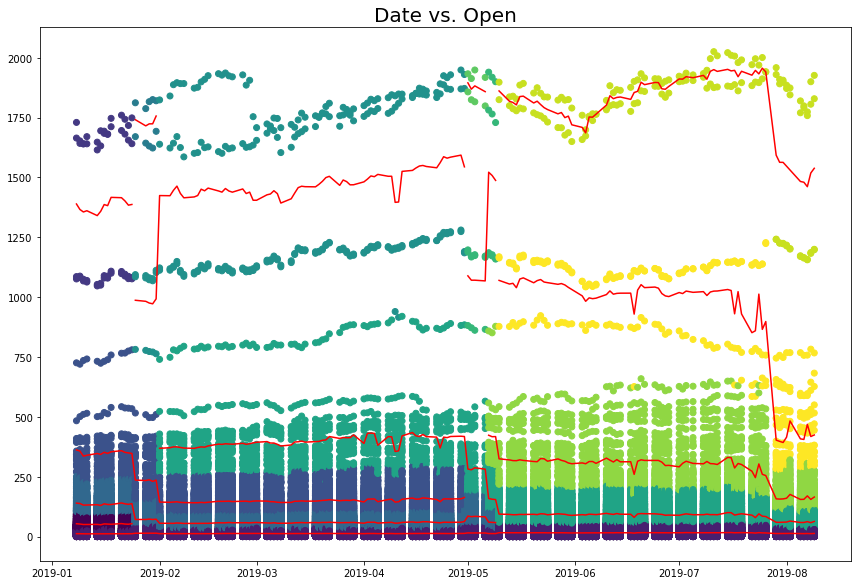

In [38]:
fig, ax = pyplot.subplots(figsize=(12, 8))
fig.tight_layout(h_pad=2)
ax.set_title("Date vs. Open", fontsize=20);
clusters = numpy.sort(pandas_dataframe["cluster_index"].unique())

ax.scatter(pandas_dataframe["date"], pandas_dataframe["open"], c=pandas_dataframe["cluster_index"]);

for cluster in clusters:
    cluster_df = pandas_dataframe[pandas_dataframe["cluster_index"] == cluster]
    ax.plot(cluster_df["date"], cluster_df["centroid"], c='red'); 

We can look at a specific ticker

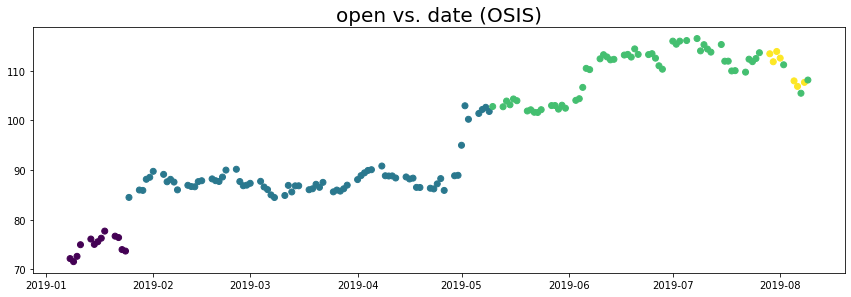

In [39]:
fig, ax = pyplot.subplots(figsize=(12, 4))
fig.tight_layout(h_pad=2)
ax.set_title("open vs. date (OSIS)", fontsize=20);
ticker_df = pandas_dataframe[pandas_dataframe["ticker"] == "OSIS"]
ax.scatter(ticker_df["date"], ticker_df["open"], c=ticker_df["cluster_index"]);

Or a group of tickers

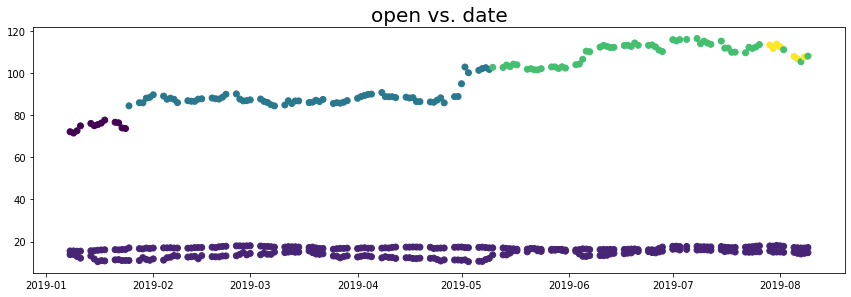

In [40]:
fig, ax = pyplot.subplots(figsize=(12, 4))
fig.tight_layout(h_pad=2)
ax.set_title("open vs. date", fontsize=20);
tickers = ["ORIT", "OPRX", "OSIS"]
ticker_df = pandas_dataframe[pandas_dataframe["ticker"].isin(tickers)]
ax.scatter(ticker_df["date"], ticker_df["open"], c=ticker_df["cluster_index"]);

# 5. Hyperparameter Tuning Over Time
We prepare a few functions to optimize our clustering algorithm.

In [44]:
import kneed
def determine_knee_point_using_kneed(model_data):
    cluster_counts = list(model_data.keys())
    knee_x = cluster_counts
    knee_y = [model_data[cluster_count]["sos"] for cluster_count in cluster_counts]
    kneedle = kneed.KneeLocator(knee_x, knee_y, S=1.0, curve="convex", direction="decreasing")
    knee = int(kneedle.knee)
    return knee

In [45]:
def same_sign(a, b):
    if a >= 0:
        if b >= 0:
            return True
        else:
            return False
    else:
        if b >= 0:
            return True
        else:
            return False
    
def is_ip(col):
    a = col.iloc[0]
    b = col.iloc[1]
    return not same_sign(a, b)

def determine_knee_point_using_acceleration(model_data):
    cluster_counts = list(model_data.keys())
    x = cluster_counts
    y = [model_data[cluster_count]["sos"] for cluster_count in cluster_counts]
    df = pandas.DataFrame({"x": x, "y": y})
    df["v"] = df["y"].diff()
    df["a"] = df["v"].diff()
    df["ip"] = df["a"].rolling(2, center=True).apply(lambda col: is_ip(col))
    i = df[df["ip"] == 1].index[0] - 1
    knee = df.loc[i, "x"]
    return knee    

In [46]:
def perform_kmeans_for_date(df, date, random_state):

    # Get a subset of our data for a particular date
    date_df = df[df["date"] == date]

    # Set the parameters for our model
    variables = ["open", "d_open", "d2_open", "ma_open", "prev_open"]    
    
    # Remove any bad data
    date_df = date_df[~date_df[variables].isin([numpy.nan, numpy.inf, -numpy.inf]).any(1)]

    # Fit the model to find a varying number of clusters
    cluster_counts = list(range(1, 31))
    model_data = {}
    for num_clusters in cluster_counts:
    
        # Create an instance of our model
        model = KMeans(n_clusters=num_clusters, random_state=random_state)

        # Fit the model
        model_parameters = date_df[variables]
        fit = model.fit(model_parameters)
        
        # Store information         
        model_data[num_clusters] = {
            "sos": model.inertia_,
            "fit": fit,
            "centroids": model.cluster_centers_,
            "model": model,            
        }

    # Determine the knee point and thus the optimal hyper parameters
    knee = determine_knee_point_using_acceleration(model_data)
    
    # Retrieve information
    fit = model_data[knee]["fit"]
    centroids = model_data[knee]["centroids"]
    model = model_data[knee]["model"]    
        
    # Set the clusters and centroids
    date_df["cluster"] = fit.labels_.astype(int)
    date_df["centroid"] = [centroids[i] for i in date_df["cluster"]]
    
    # Add the information back to the dataframe
    df.update(date_df)
    
    return date_df

# Sanity check the code is working
df_07_12_2019 = perform_kmeans_for_date(pandas_dataframe, '2019-07-12', 42)

We can then apply this function to our cluster analysis of all dates

In [47]:
# Set params for the kmeans
random_state = 42

# Create a mapping table to keep track of cluster id's and indexes
cms = ClusterMappingSeries()

# Determine what dates need to be calculated
variables = ["open", "d_open", "d2_open", "ma_open", "prev_open"]
pandas_dataframe = pandas_dataframe[~pandas_dataframe[variables].isin([numpy.nan, numpy.inf, -numpy.inf]).any(1)]
dates = numpy.sort(pandas_dataframe["date"].unique())

# Create a progress bar to keep us updates while the numbers crunch
num_ops = len(dates)
progress_bar_widgets = [
    progressbar.Bar('=', '[', ']'), 
    ' ', 
    progressbar.FormatLabel('Processed: %(value)d / {0} ops'.format(num_ops)),
    ' ', 
    progressbar.ETA()
]
bar = progressbar.ProgressBar(maxval=num_ops, widgets=progress_bar_widgets)
bar.start()
count = 0

# Loop through the next dates, do a mapping, resolve the indexes, plot them
for i in range(0, len(dates)):
    
    # Retrieve info from dataframe, perform kmeans, package cluster info as a cluster set
    date = dates[i]
    date_df = perform_kmeans_for_date(pandas_dataframe, date, random_state)
    pandas_dataframe.loc[date_df.index, "centroid"] = date_df["centroid"]
    
    # Map the previous cluster to this one
    cluster_set = date_df_to_cluster_set(date_df)
    cms.add_cluster_set(cluster_set)
    
    # If we do not have a mapping yet, continue
    if i == 0:
        count += 1
        bar.update(count)
        continue
   
    # Loop through the clusters, update the df, plot the result
    for j in range(0, len(cluster_set)):
        
        # Get the cluster index
        cluster = cluster_set[j]
        cluster_index = cms.id_to_index_mapping[cluster.id]
        cluster_id = cluster.id
        
        # Update the dataframe with the corrected cluster information
        cluster_df = date_df[date_df["cluster"] == j]
        pandas_dataframe.loc[cluster_df.index, "cluster_id"] = cluster_id
        pandas_dataframe.loc[cluster_df.index, "cluster_index"] = cluster_index
        
    # Reasmple our original dataframe to pickup changes
    date_df = pandas_dataframe[pandas_dataframe["date"] == date]

    # Plot each cluster   
    count += 1
    bar.update(count)

In [48]:
pandas_dataframe.head()

,ticker,interval,date,open,high,low,close,volume,d_open,d2_open,ma_open,prev_open,centroid,cluster_id,cluster_index
108484,ORGS,D,2019-01-07,4.94000,5.08000,4.87000,5.03000,4600.00000,0.30000,0.61000,4.72600,4.64000,"[4.70217826714801, 0.12894440433213028, 0.1096...",nan,nan
108483,ORG,D,2019-01-07,25.46000,25.66000,25.46000,25.62000,1800.00000,0.06000,-0.66000,24.97000,25.40000,"[19.977112412177984, 0.3584660421545666, 0.301...",nan,nan
108482,ORBC,D,2019-01-07,8.53000,8.81000,8.49000,8.66000,359800.00000,0.11000,0.15000,8.36600,8.42000,"[4.70217826714801, 0.12894440433213028, 0.1096...",nan,nan
108478,OPRA,D,2019-01-07,6.22000,6.32000,6.17000,6.24000,126200.00000,0.09000,0.03000,5.89800,6.13000,"[4.70217826714801, 0.12894440433213028, 0.1096...",nan,nan
108480,OPTN,D,2019-01-07,7.09000,7.61000,6.68000,7.50000,392900.00000,0.29000,0.29000,6.61800,6.80000,"[4.70217826714801, 0.12894440433213028, 0.1096...",nan,nan


And we can plot the data over time to understand how the algorithm performed

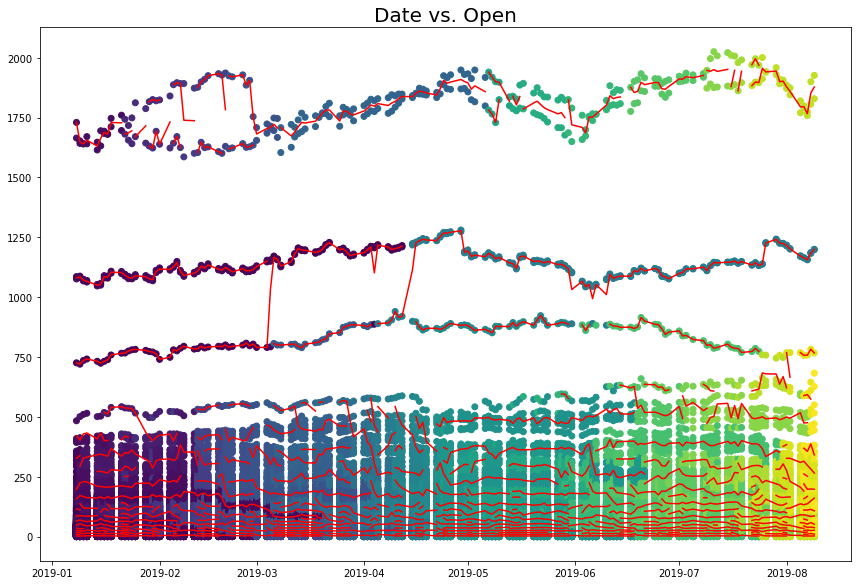

In [49]:
fig, ax = pyplot.subplots(figsize=(12, 8))
fig.tight_layout(h_pad=2)
ax.set_title("Date vs. Open", fontsize=20);
clusters = numpy.sort(pandas_dataframe["cluster_index"].unique())

ax.scatter(pandas_dataframe["date"], pandas_dataframe["open"], c=pandas_dataframe["cluster_index"]);

for cluster in clusters:
    cluster_df = pandas_dataframe[pandas_dataframe["cluster_index"] == cluster]
    cluster_centroids = cluster_df["centroid"]
    open_centroid = cluster_centroids.apply(lambda x: x[0])
    ax.plot(cluster_df["date"], open_centroid, c='red'); 

# 6. Analyze Cluster Data

We can determine the cluster colors being used

In [50]:
# Import the color map and webcolor libraries to help us identify the colors assigned in our visualization

import matplotlib.cm as cm
import webcolors

# When we used pyplot earlier to create a scatter plot, we used the cluster indexes as a color code
# Behind the scenes, pyplot uses the viridis color map (by default) to convert numbers into colors.
# It does this by normalizing the integer values according to the cluster index range and then
# looking up the coresponding hexadecimal color value for the coresponding normalized value 
# We needed to do some magic to reverse engineer the process

def int_to_hex(value, cmap_name='viridis', vmin=0, vmax=1):
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)
    rgb = cmap(norm(abs(value)))[:3]
    color = matplotlib.colors.rgb2hex(rgb)
    return color

# Mapping the hexedecimal number to the human friendly name is a tricky subject.
# For a small craction of colors, theres is a CSS standard which dictates a name for the code
# For all the rest... there is no standard
# I have seen implimentations where a site (like xkcd) takes a survey of the color names and provides a lookup table
# I have taken a hybrid approach:
# We have the CSS lookups and we have some exact matches in a lookup table
# I use a function to find the closest value mathematically

file_path = "rgb.txt"
color_dataframe = pandas.read_csv(file_path, names=["name", "hex"], header=None, comment='!', skip_blank_lines=True)
color_dataframe.head()
    
def closest_colour(rgb_tuple):

    min_colours = {}
    for i, row in color_dataframe.iterrows():
        color_name = row["name"]
        color_hex = row["hex"]
        r_c, g_c, b_c = webcolors.hex_to_rgb(color_hex)
        rd = (r_c - rgb_tuple[0]) ** 2
        gd = (g_c - rgb_tuple[1]) ** 2
        bd = (b_c - rgb_tuple[2]) ** 2
        min_colours[(rd + gd + bd)] = color_name
    return min_colours[min(min_colours.keys())]

In [52]:
# Get paramters for the color conversion
vmin = pandas_dataframe['cluster_index'].min()
vmax = pandas_dataframe['cluster_index'].max()
color_df = pandas.DataFrame({}, columns=["cluster_index", "color hex", "rgb", "color name"])
cluster_numbers = numpy.sort(pandas_dataframe["cluster_index"].unique())
for cluster_number in cluster_numbers:    
    color_hex = int_to_hex(cluster_number, vmin=vmin, vmax=vmax)
    color_rgb = tuple(webcolors.hex_to_rgb(color_hex))
    color_name = closest_colour(color_rgb)
    color_df = color_df.append({
        "cluster_index": cluster_number, 
        "color hex": color_hex, 
        "rgb": color_rgb, 
        "color name": color_name
    }, ignore_index=True)

In [53]:
color_df

,cluster_index,color hex,rgb,color name
0,0.00000,#440154,"(68, 1, 84)",dark purple
1,2.00000,#440256,"(68, 2, 86)",dark purple
2,3.00000,#450457,"(69, 4, 87)",dark purple
3,4.00000,#450457,"(69, 4, 87)",dark purple
4,5.00000,#450559,"(69, 5, 89)",dark purple
...,...,...,...,...
357,358.00000,#f8e621,"(248, 230, 33)",gold
358,359.00000,#fbe723,"(251, 231, 35)",gold
359,360.00000,#fde725,"(253, 231, 37)",gold
360,361.00000,#fde725,"(253, 231, 37)",gold


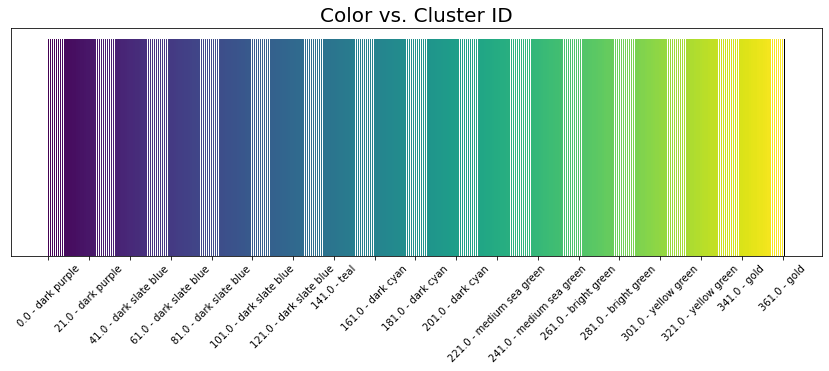

In [54]:
fig, ax = pyplot.subplots(figsize=(12, 4))
ax.set_title("Color vs. Cluster ID", fontsize=20);
fig.tight_layout(h_pad=2)
ax.get_yaxis().set_visible(False)
ax.tick_params(axis='x', labelrotation=45)

bar_names = color_df.apply(lambda row: "{0} - {1}".format(row.cluster_index, row["color name"]) , axis = 1)
bar_heights = [1 for x in color_df["cluster_index"]]
bar_colors = color_df["color hex"]

# We need to do some magic to make the axis more readable
# We will not show the names of every cluster/color but will show wvery 10
# They are too close together and will overload the axis otherwise

group_size = 20
indexes_to_be_shown = numpy.arange(0, color_df.shape[0] + 1, group_size)
names_to_be_shown = [bar_names[x] for x in indexes_to_be_shown]
ax.set(xticks=indexes_to_be_shown, xticklabels=names_to_be_shown)

ax.bar(bar_names, bar_heights, color=bar_colors);

We can show the cluster counts over time to visualize splits and merges in our clusters. An increase in cluster count indicates a split while a decrease in cluster count indicates a merge.

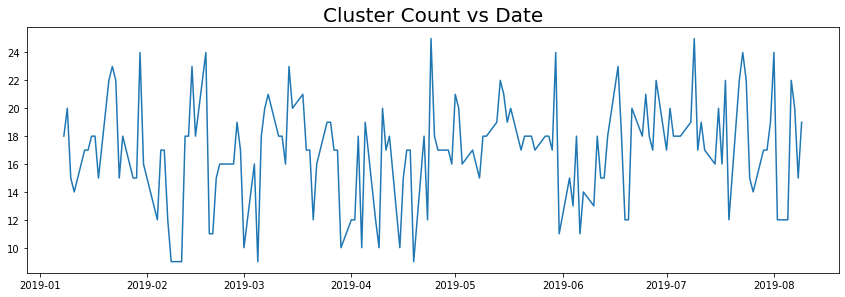

In [55]:
fig, ax = pyplot.subplots(figsize=(12, 4))
fig.tight_layout(h_pad=2)
ax.set_title("Cluster Count vs Date", fontsize=20);
cluster_counts = []
for date in dates[1:]:
    cluster_count = len(pandas_dataframe[pandas_dataframe["date"] == date]["cluster_index"].unique())
    cluster_counts.append(cluster_count)
    
ax.plot(dates[1:], cluster_counts);

We can look at clutester lifetimes to get an understanding of what clusters are long lived and what are short lived. We will count the number of days that a particular cluster was around for.

In [56]:
cluster_index_count = pandas_dataframe["cluster_index"].unique().shape[0]
counts = numpy.zeros([cluster_index_count], dtype=int, order='C')
dates = numpy.sort(pandas_dataframe["date"].unique())
for date in dates:
    date_df = pandas_dataframe[pandas_dataframe["date"] == date]
    date_cluster_indexes = date_df["cluster_index"].unique()
    for date_cluster_index in date_cluster_indexes:
        if not pandas.isna(date_cluster_index):            
            counts[int(date_cluster_index)] += 1

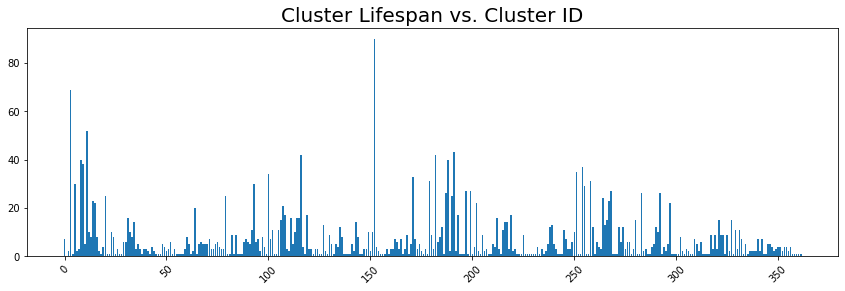

In [57]:
fig, ax = pyplot.subplots(figsize=(12, 4))
ax.set_title("Cluster Lifespan vs. Cluster ID", fontsize=20);
fig.tight_layout(h_pad=2)
ax.get_yaxis()
ax.tick_params(axis='x', labelrotation=45)

x = list(range(0, cluster_index_count))
y = counts
ax.bar(x, counts);

We can look at the cluster life accross a timeline to understand how the groups of clusters behave

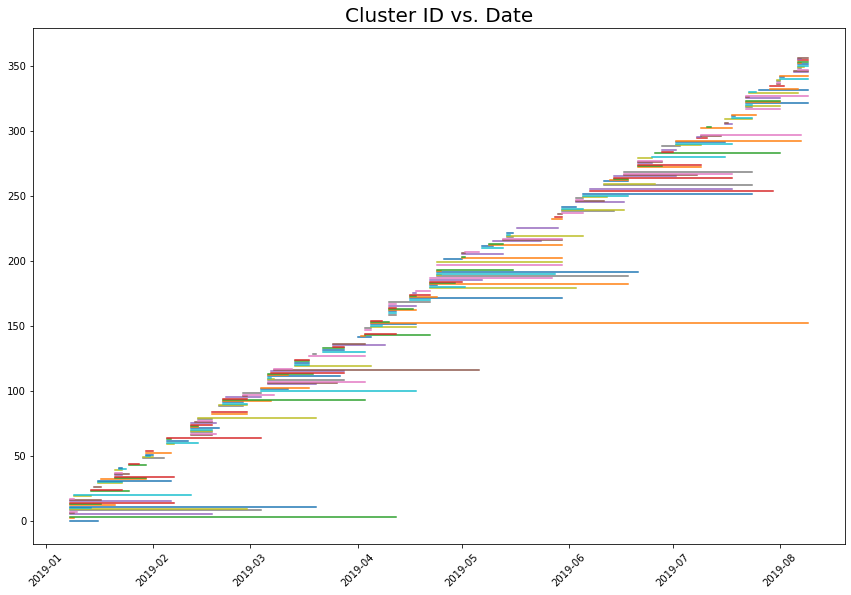

In [82]:
fig, ax = pyplot.subplots(figsize=(12, 8))
ax.set_title("Cluster ID vs. Date", fontsize=20);
fig.tight_layout(h_pad=2)
ax.get_yaxis()
ax.tick_params(axis='x', labelrotation=45)

cluster_lifespans = pandas_dataframe.groupby(["cluster_index"], as_index=False).agg({"date": ["min", "max"]})

for index, row in cluster_lifespans.iterrows():
    cluster_index = int(row["cluster_index"])
    min_date = row["date", "min"]
    max_date = row["date", "max"]
    lifespan = (max_date - min_date).days + 1
    
    y = [cluster_index, cluster_index]
    x = [min_date, max_date]
    
    ax.plot(x, y)

Graph the cluster id for each ticker over time... shows how tickers change membership

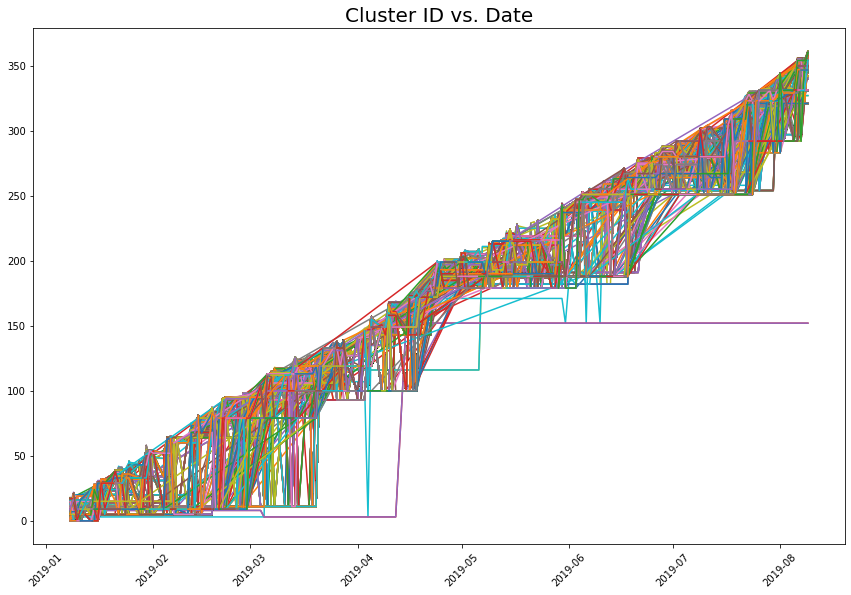

In [182]:
fig, ax = pyplot.subplots(figsize=(12, 8))
ax.set_title("Cluster ID vs. Date", fontsize=20);
fig.tight_layout(h_pad=2)
ax.get_yaxis()
ax.tick_params(axis='x', labelrotation=45)

tickers = pandas_dataframe["ticker"].unique()
for ticker in tickers:
    ticker_df = pandas_dataframe[pandas_dataframe["ticker"] == ticker]
    ax.plot(ticker_df["date"], ticker_df["cluster_index"])

We can look at when clusters are destroyed andd created

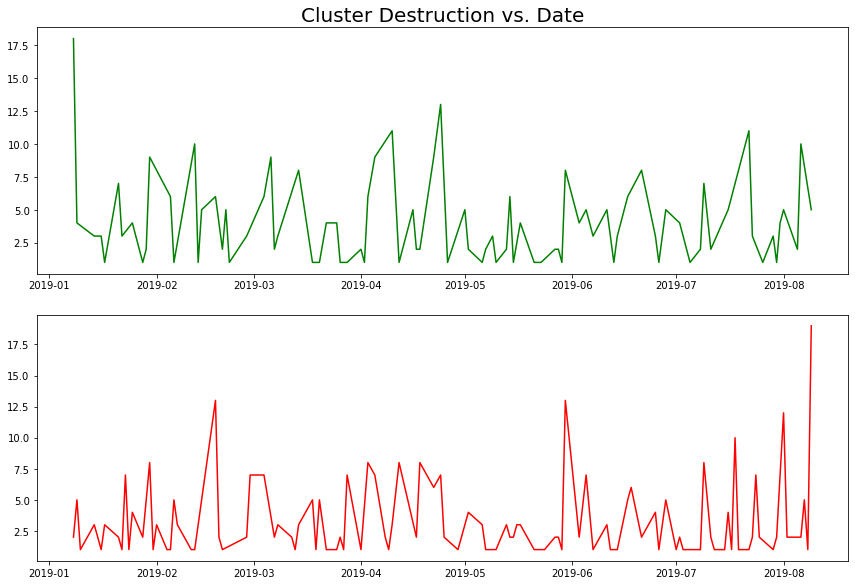

In [178]:
# Convert the multindex into a regular index
cluster_lifespans.columns = cluster_lifespans.columns.map(''.join)

# For each date, count the number of clusters that are created
cluster_starts = cluster_lifespans.groupby("datemin").count()
cluster_ends = cluster_lifespans.groupby("datemax").count()

# Create plot objects
fig, ax = pyplot.subplots(figsize=(12, 8), nrows=2, ncols=1)
fig.tight_layout(h_pad=2)

ax[0].set_title("Cluster Cration vs. Date", fontsize=20);
ax[0].set_title("Cluster Destruction vs. Date", fontsize=20);

# Plot the data
ax[0].plot(cluster_starts.index, cluster_starts["cluster_index"], c='green')
ax[1].plot(cluster_ends.index, cluster_ends["cluster_index"], c='red');

We can look at cluster sizes over time

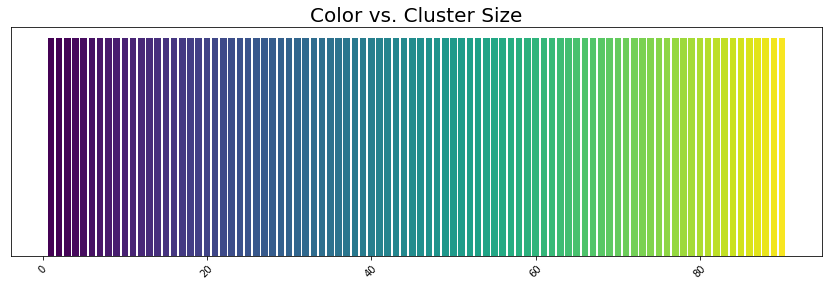

In [136]:
max_cluster_lifespan = counts.max()

vmin = 1
vmax = max_cluster_lifespan

bar_names = range(1, max_cluster_lifespan + 1)
bar_heights = [1 for x in range(0, max_cluster_lifespan)]
bar_colors = [int_to_hex(x, vmin=vmin, vmax=vmax) for x in range(0, max_cluster_lifespan)]

fig, ax = pyplot.subplots(figsize=(12, 4))
ax.set_title("Color vs. Cluster Size", fontsize=20);
fig.tight_layout(h_pad=2)
ax.get_yaxis().set_visible(False)
ax.tick_params(axis='x', labelrotation=45)

ax.bar(bar_names, bar_heights, color=bar_colors);

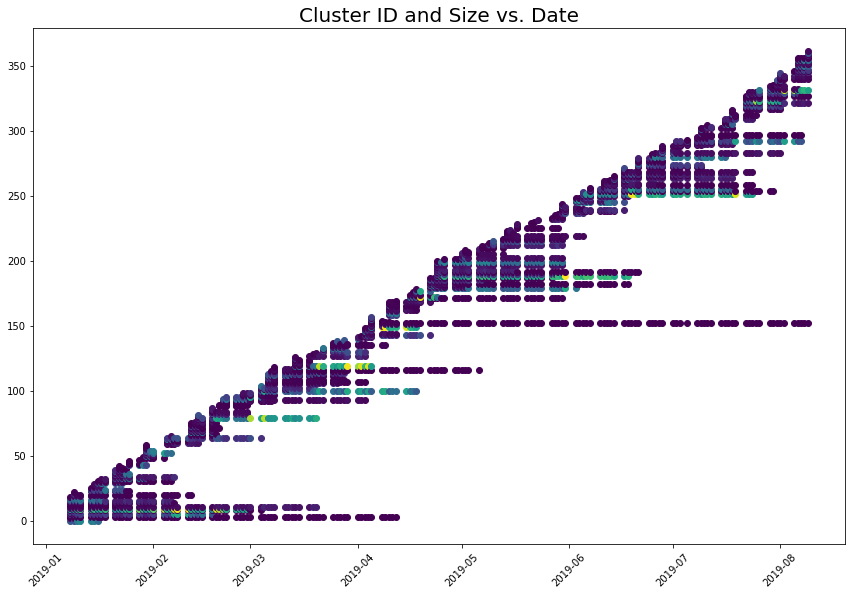

In [177]:
fig, ax = pyplot.subplots(figsize=(12, 8))
ax.set_title("Cluster ID and Size vs. Date", fontsize=20);
fig.tight_layout(h_pad=2)
ax.get_yaxis()
ax.tick_params(axis='x', labelrotation=45)

# Calculate a dataframe that explains the members of a cluster over time
cluster_sizes_over_time = pandas_dataframe[["date", "cluster_index", "ticker"]].groupby(["date", "cluster_index"]).agg({"ticker": ["count"]})
cluster_sizes_over_time = cluster_sizes_over_time.reset_index(level=[0,1])

# Set some params for calculating colors based on size
vmin = 1
vmax = cluster_sizes_over_time["ticker", "count"].max()

# Get a list of dates
cluster_sizes_over_time["date"].unique()

# Setup a progressbar
num_ops = len(dates)
progress_bar_widgets = [
    progressbar.Bar('=', '[', ']'), 
    ' ', 
    progressbar.FormatLabel('Processed: %(value)d / {0} ops'.format(num_ops)),
    ' ', 
    progressbar.ETA()
]
bar = progressbar.ProgressBar(maxval=num_ops, widgets=progress_bar_widgets)
bar.start()
count = 0

for date in dates:
    date_df = cluster_sizes_over_time[cluster_sizes_over_time["date"] == date]
    for cluster_index in date_df["cluster_index"]:
        cluster_df = date_df[date_df["cluster_index"] == cluster_index]
        member_count = int(cluster_df["ticker", "count"])
        member_count_color = int_to_hex(member_count, vmin=vmin, vmax=vmax)
        ax.scatter(date, cluster_index, c=member_count_color)
        
    # Update the progress bar   
    count += 1
    bar.update(count)


We can look at when tickers change membership
ticker (change) vs date

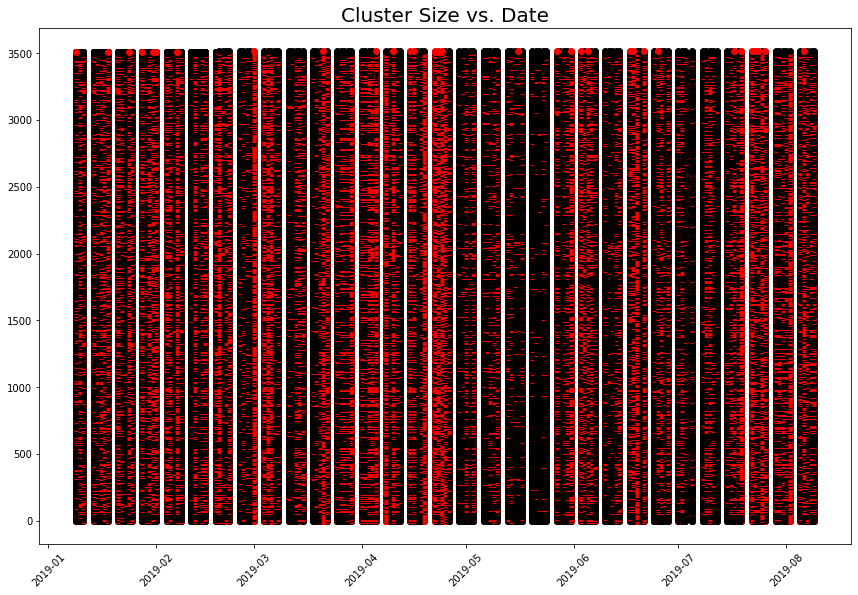

In [276]:
fig, ax = pyplot.subplots(figsize=(12, 8))
ax.set_title("Cluster Size vs. Date", fontsize=20);
fig.tight_layout(h_pad=2)
ax.get_yaxis()
ax.tick_params(axis='x', labelrotation=45)

tickers = sorted(cluster_info["ticker"].unique())

cluster_info = pandas_dataframe[["date", "ticker", "cluster_index"]].copy()
cluster_info = cluster_info.dropna()

#ax.set_ylabel(tickers)

for i in range(0, len(tickers)):
    ticker = tickers[i]
    
    ticker_df = cluster_info[cluster_info["ticker"] == ticker].copy()
    ticker_df.loc[ticker_df.index, "cluster_change"] = ticker_df["cluster_index"].rolling(2).apply(lambda window: int(window.iloc[0] != window.iloc[1]))
    ticker_df.loc[ticker_df.index, "ticker_index"] = [i for x in range(0, len(ticker_df))]
    
    cluster_info.loc[ticker_df.index, "cluster_change"] = ticker_df.loc[ticker_df.index, "cluster_change"]
    cluster_info.loc[ticker_df.index, "ticker_index"] = ticker_df.loc[ticker_df.index, "ticker_index"]
    
    # plot the changes red and the other points black
    changes = ticker_df[ticker_df["cluster_change"] == 0]    
    ax.scatter(changes["date"], [i for x in range(0, len(changes))], c='black')
    changes = ticker_df[ticker_df["cluster_change"] == 1]    
    ax.scatter(changes["date"], [i for x in range(0, len(changes))], c='red')

We can plot the number of cluster changes over time

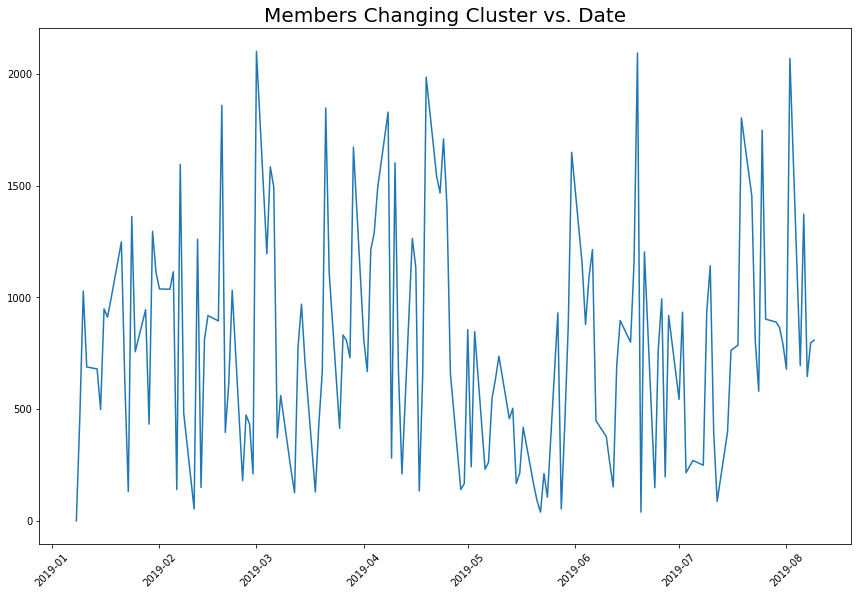

In [279]:
fig, ax = pyplot.subplots(figsize=(12, 8))
ax.set_title("Members Changing Cluster vs. Date", fontsize=20);
fig.tight_layout(h_pad=2)
ax.get_yaxis()
ax.tick_params(axis='x', labelrotation=45)

cluster_changes = cluster_info.groupby("date").agg({"cluster_change": ["sum"]})
ax.plot(cluster_changes.index, cluster_changes['cluster_change', 'sum']);


We can look at the size of a cluster relative to the total number of tickers over time

In [239]:
ticker_count = len(pandas_dataframe["ticker"].unique())
dates = numpy.sort(pandas_dataframe["date"].unique())

cluster_size_df = pandas.DataFrame(columns=["cluster_index","date","member_count"])

for date in dates:
    date_df = pandas_dataframe[pandas_dataframe["date"] == date]
    cluster_indexes_for_date = date_df["cluster_index"].unique()
    for cluster_index in cluster_indexes_for_date:
        if pandas.isna(cluster_index):
            continue
        cluster_df = date_df[date_df["cluster_index"] == cluster_index]
        member_count = len(cluster_df["ticker"].unique())
        cluster_size_df = cluster_size_df.append({
            "cluster_index": cluster_index,
            "date": date,
            "member_count": member_count,
            "membership_percentage": member_count / len(date_df["ticker"].unique())
        }, ignore_index=True)

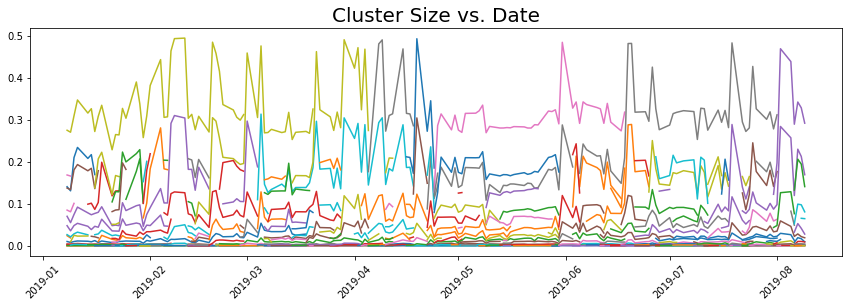

In [240]:
fig, ax = pyplot.subplots(figsize=(12, 4))
ax.set_title("Relative Cluster Size vs. Date", fontsize=20);
fig.tight_layout(h_pad=2)
ax.get_yaxis()
ax.tick_params(axis='x', labelrotation=45)

for cluster_index in numpy.sort(cluster_size_df["cluster_index"].unique()):
    cluster_df = cluster_size_df[cluster_size_df["cluster_index"] == cluster_index]
    x = cluster_df["date"]
    y = cluster_df["membership_percentage"]
    ax.plot(x, y);


In [ ]:
We can look at cluster characteristics, like stddev, over time.

We can look at cluter distributions through time

In [ ]:
We can look at cluster membership through time

We can plot a single cluster over time

In [179]:
max_cluster_life = max(counts)
max_cluster_index = 0
for index in range(0, len(counts)):
    life = counts[index]
    if life >= max_cluster_life:
        max_cluster_index = index
cluster_df = pandas_dataframe[pandas_dataframe["cluster_index"] == max_cluster_index]

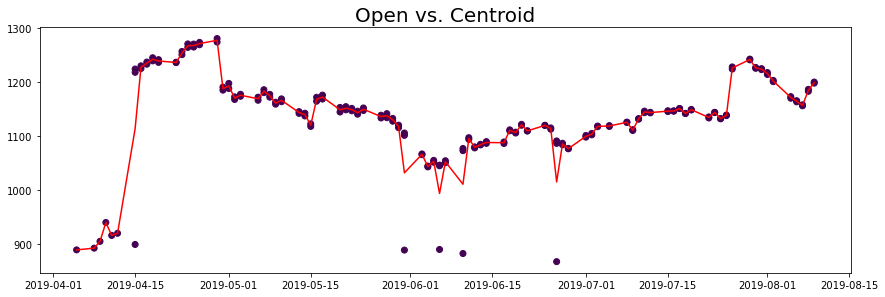

In [183]:
fig, ax = pyplot.subplots(figsize=(12, 4))
fig.tight_layout(h_pad=2)
ax.set_title("Open vs. Centroid", fontsize=20);
clusters = numpy.sort(pandas_dataframe["cluster_index"].unique())

ax.scatter(cluster_df["date"], cluster_df["open"], c=cluster_df["cluster_index"]);
ax.plot(cluster_df["date"], cluster_df["centroid"].apply(lambda x: x[0]), c='red');

We can take a starting cluster and look at how its members changed over time

In [191]:
cluster_df = pandas_dataframe[pandas_dataframe["cluster_index"] == max_cluster_index]
cluster_dates = numpy.sort(cluster_df["date"].unique())
start_date = cluster_dates[0]
end_date = cluster_dates[-1]
print("start date: {0}".format(start_date))
print("end date: {0}".format(end_date))
start_members = cluster_df[cluster_df["date"] == start_date]["ticker"].unique()
start_members

start date: 2019-04-05T00:00:00.000000000
end date: 2019-08-09T00:00:00.000000000


array(['ATRI'], dtype=object)